2.3.7 Kernelized Support Vector Machines
The next type of supervised model we will discuss is kernelized support vector machines. We explored the use of linear support vector machines for classification in “Linear models for classification”. Kernelized support vector machines (often just referred to as SVMs) are an extension that allows for more complex models that are not defined simply by hyperplanes in the input space. While there are support vector machines for classification and regression, we will restrict ourselves to the classification case, as implemented in SVC. Similar concepts apply to support vector regression, as implemented in SVR.

The math behind kernelized support vector machines is a bit involved, and is beyond the scope of this course. You can 
find the details in Chapter 12 of Hastie, Tibshirani, and Friedman’s The Elements of Statistical Learning. However, we will try to give you some sense of the idea behind the method.


LINEAR MODELS AND NONLINEAR FEATURES
As you saw in the last class, linear models can be quite limiting in low-dimensional spaces, as lines and hyperplanes 
have 
limited
flexibility. One way to make a linear model more flexible is by adding more features—for example, by adding interactions or polynomials of the input features.

Let’s look at the synthetic dataset we used above in “Feature importance in trees” :

Text(0, 0.5, 'Feature 1')

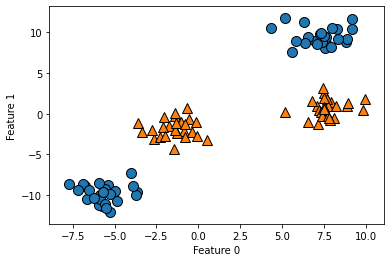

In [1]:
from sklearn.datasets import make_blobs
import mglearn
import matplotlib.pyplot as plt

X, y = make_blobs(centers=4, random_state=8)
y = y % 2

mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

A linear model for classification can only separate points using a line, and will not be able to do a very good job \
        on this dataset (see Figure below):
    

Text(0, 0.5, 'Feature 1')

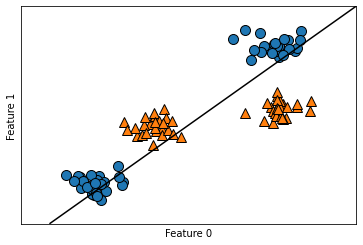

In [2]:
from sklearn.svm import LinearSVC
linear_svm = LinearSVC(max_iter=10000).fit(X, y)

mglearn.plots.plot_2d_separator(linear_svm, X)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

Now let’s expand the set of input features, say by also adding feature1 ** 2, the square of the second feature, as a 
new feature. Instead of representing each data point as a two-dimensional point, (feature0, feature1), we now 
represent it as a three-dimensional point, (feature0, feature1, feature1 ** 2) This new representation is illustrated\
                                                                                        in the figure below in a 
three-dimensional
scatter plot:

Text(0.5, 0, 'feature1 ** 2')

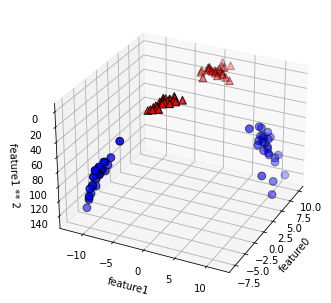

In [3]:
import numpy as np
# add the squared second feature
X_new = np.hstack([X, X[:, 1:] ** 2])

from mpl_toolkits.mplot3d import Axes3D, axes3d
figure = plt.figure()
# visualize in 3D
ax = Axes3D(figure, elev=-152, azim=-26)
# plot first all the points with y == 0, then all with y == 1
mask = y == 0
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b',
           cmap=mglearn.cm2, s=60, edgecolor='k')
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^',
           cmap=mglearn.cm2, s=60, edgecolor='k')
ax.set_xlabel("feature0")
ax.set_ylabel("feature1")
ax.set_zlabel("feature1 ** 2")

In the new representation of the data, it is now indeed possible to separate the two classes using a linear model, a 
plane in three dimensions. We can confirm this by fitting a linear model to the augmented data (see Figure below):

Text(0.5, 0, 'feature1 ** 2')

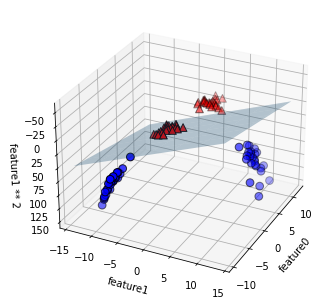

In [4]:
linear_svm_3d = LinearSVC(max_iter=10000).fit(X_new, y)
coef, intercept = linear_svm_3d.coef_.ravel(), linear_svm_3d.intercept_

# show linear decision boundary
figure = plt.figure()
ax = Axes3D(figure, elev=-152, azim=-26)
xx = np.linspace(X_new[:, 0].min() - 2, X_new[:, 0].max() + 2, 50)
yy = np.linspace(X_new[:, 1].min() - 2, X_new[:, 1].max() + 2, 50)

XX, YY = np.meshgrid(xx, yy)
ZZ = (coef[0] * XX + coef[1] * YY + intercept) / -coef[2]
ax.plot_surface(XX, YY, ZZ, rstride=8, cstride=8, alpha=0.3)
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b',
           cmap=mglearn.cm2, s=60, edgecolor='k')
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^',
           cmap=mglearn.cm2, s=60, edgecolor='k')

ax.set_xlabel("feature0")
ax.set_ylabel("feature1")
ax.set_zlabel("feature1 ** 2")

As a function of the original features, the linear SVM model is not actually linear anymore. It is not a line, but 
more of an ellipse, as you can see from the plot created here (Figure below):

Text(0, 0.5, 'Feature 1')

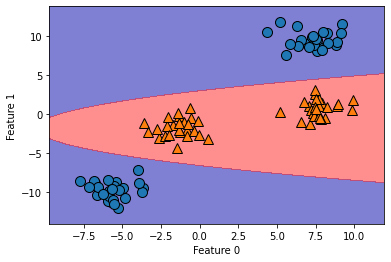

In [5]:
ZZ = YY ** 2
dec = linear_svm_3d.decision_function(np.c_[XX.ravel(), YY.ravel(), ZZ.ravel()])
plt.contourf(XX, YY, dec.reshape(XX.shape), levels=[dec.min(), 0, dec.max()],
             cmap=mglearn.cm2, alpha=0.5)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

THE KERNEL TRICK
The lesson here is that adding nonlinear features to the representation of our data can make linear models much more powerful. However, often we don’t know which features to add, and adding many features (like all possible interactions in a 100-dimensional feature space) might make computation very expensive. Luckily, there is a clever mathematical trick that allows us to learn a classifier in a higher-dimensional space without actually computing the new, possibly very large representation. This is known as the kernel trick, and it works by directly computing the distance (more precisely, the scalar products) of the data points for the expanded feature representation, without ever actually computing the expansion.

There are two ways to map your data into a higher-dimensional space that are commonly used with support vector machines: the polynomial kernel, which computes all possible polynomials up to a certain degree of the original features (like feature1 ** 2 * feature2 ** 5); and the radial basis function (RBF) kernel, also known as the Gaussian kernel. The Gaussian kernel is a bit harder to explain, as it corresponds to an infinite-dimensional feature space. One way to explain the Gaussian kernel is that it considers all possible polynomials of all degrees, but the importance of the features decreases for higher degrees.11

In practice, the mathematical details behind the kernel SVM are not that important, though, and how an SVM with an RBF kernel makes a decision can be summarized quite easily—we’ll do so in the next section.

UNDERSTANDING SVMS
During training, the SVM learns how important each of the training data points is to represent the decision boundary between the two classes. Typically only a subset of the training points matter for defining the decision boundary: the ones that lie on the border between the classes. These are called support vectors and give the support vector machine its name.

To make a prediction for a new point, the distance to each of the support vectors is measured. A classification decision is made based on the distances to the support vector, and the importance of the support vectors that was learned during training (stored in the dual_coef_ attribute of SVC).
    

The distance between data points is measured by the Gaussian kernel:

krbf(x1, x2) = exp (–ɣǁx1 - x2ǁ2)
Here, x1 and x2 are data points, ǁ x1 - x2 ǁ denotes Euclidean distance, and ɣ (gamma) is a parameter that controls the width of the Gaussian kernel.

The figure below shows the result of training a support vector machine on a two-dimensional two-class dataset. The \
        decision boundary is shown in black, and the support vectors are larger points with the wide outline. The following code creates this plot by training an SVM on the forge dataset:
    

Text(0, 0.5, 'Feature 1')

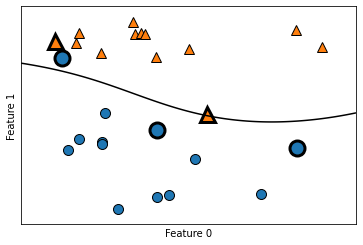

In [3]:
from sklearn.svm import SVC
X, y = mglearn.tools.make_handcrafted_dataset()
svm = SVC(kernel='rbf', C=10, gamma=0.1).fit(X, y)
mglearn.plots.plot_2d_separator(svm, X, eps=.5)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
# plot support vectors
sv = svm.support_vectors_
# class labels of support vectors are given by the sign of the dual coefficients
sv_labels = svm.dual_coef_.ravel() > 0
mglearn.discrete_scatter(sv[:, 0], sv[:, 1], sv_labels, s=15, markeredgewidth=3)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

In this case, the SVM yields a very smooth and nonlinear (not a straight line) boundary. We adjusted two parameters here: the C parameter and the gamma parameter, which we will now discuss in detail.

TUNING SVM PARAMETERS
The gamma parameter is the one shown in the formula given in the previous section, which corresponds to the inverse of the width of the Gaussian kernel. Intuitively, the gamma parameter determines how far the influence of a single training example reaches, with low values meaning corresponding to a far reach, and high values to a limited reach. In other words, the wider the radius of the Gaussian kernel, the further the influence of each training example. The C parameter is a regularization parameter, similar to that used in the linear models. It limits the importance of each point (or more precisely, their dual_coef_).

Let’s have a look at what happens when we vary these parameters (see below figure):

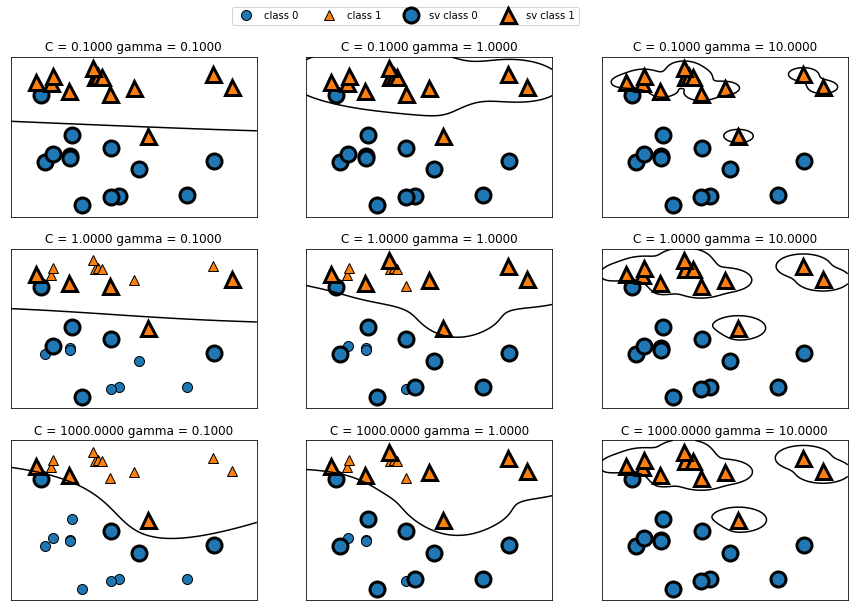

In [7]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))

for ax, C in zip(axes, [-1, 0, 3]):
    for a, gamma in zip(ax, range(-1, 2)):
        mglearn.plots.plot_svm(log_C=C, log_gamma=gamma, ax=a)

axes[0, 0].legend(["class 0", "class 1", "sv class 0", "sv class 1"],
                  ncol=4, loc=(.9, 1.2))

Going from left to right, we increase the value of the parameter gamma from 0.1 to 10. A small gamma means a large radius for the Gaussian kernel, which means that many points are considered close by. This is reflected in very smooth decision boundaries on the left, and boundaries that focus more on single points further to the right. A low value of gamma means that the decision boundary will vary slowly, which yields a model of low complexity, while a high value of gamma yields a more complex model.

Going from top to bottom, we increase the C parameter from 0.1 to 1000. As with the linear models, a small C means a very restricted model, where each data point can only have very limited influence. You can see that at the top left the decision boundary looks nearly linear, with the misclassified points barely having any influence on the line. Increasing C, as shown on the bottom left, allows these points to have a stronger influence on the model and makes the decision boundary bend to correctly classify them.

Let’s apply the RBF kernel SVM to the Breast Cancer dataset. By default, C=1 and gamma=1/n_features:

In [5]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

svc = SVC()
svc.fit(X_train, y_train)

print("Accuracy on training set: {:.2f}".format(svc.score(X_train, y_train)))
print("Accuracy on test set: {:.2f}".format(svc.score(X_test, y_test)))

Accuracy on training set: 0.90
Accuracy on test set: 0.94


The model overfits quite substantially, with a perfect score on the training set and only 63% accuracy on the test \
        set. While SVMs often perform quite well, they are very sensitive to the settings of the parameters and to \
        the scaling of the data. In particular, they require all the features to vary on a similar scale. Let’s look \
        at the minimum and maximum values for each feature, plotted in log-space (figure below):
    

Text(0, 0.5, 'Feature magnitude')

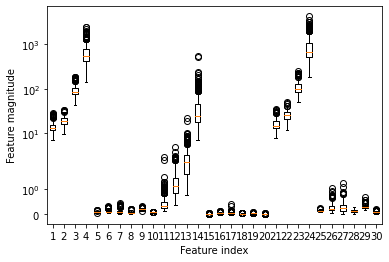

In [6]:
plt.boxplot(X_train)
plt.yscale("symlog")
plt.xlabel("Feature index")
plt.ylabel("Feature magnitude")

From this plot we can determine that features in the Breast Cancer dataset are of completely different orders of magnitude. This can be somewhat of a problem for other models (like linear models), but it has devastating effects for the kernel SVM. Let’s examine some ways to deal with this issue.
    

PREPROCESSING DATA FOR SVMS
One way to resolve this problem is by rescaling each feature so that they are all approximately on the same scale. A 
common rescaling method for kernel SVMs is to scale the data such that all features have 0 mean and unit variance, or\
        that all features are between 0 and 1. We will see how to do this using the StandardScaler or MinMaxScaler \
        preprocessing method in a future class, where we’ll give more details. The best choice of preprocessing method \
        depends on the properties of the dataset. For now, let’s do this “by hand”:
    

In [7]:
# compute the minimum value per feature on the training set
min_on_training = X_train.min(axis=0)
# compute the range of each feature (max - min) on the training set
range_on_training = (X_train - min_on_training).max(axis=0)

# subtract the min, and divide by range
# afterward, min=0 and max=1 for each feature
X_train_scaled = (X_train - min_on_training) / range_on_training
print("Minimum for each feature\n", X_train_scaled.min(axis=0))
print("Maximum for each feature\n", X_train_scaled.max(axis=0))

Minimum for each feature
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
Maximum for each feature
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]


In [8]:
# use THE SAME transformation on the test set,
# using min and range of the training set 
X_test_scaled = (X_test - min_on_training) / range_on_training

In [9]:
svc = SVC()
svc.fit(X_train_scaled, y_train)

print("Accuracy on training set: {:.3f}".format(
        svc.score(X_train_scaled, y_train)))
print("Accuracy on test set: {:.3f}".format(svc.score(X_test_scaled, y_test)))

Accuracy on training set: 0.984
Accuracy on test set: 0.972


Scaling the data made a huge difference! Now we are actually in an underfitting regime, where training and test set performance are quite similar but less close to 100% accuracy. From here, we can try increasing either C or gamma to fit a more complex model. For example:

In [10]:
svc = SVC(C=1000)
svc.fit(X_train_scaled, y_train)

print("Accuracy on training set: {:.3f}".format(
    svc.score(X_train_scaled, y_train)))
print("Accuracy on test set: {:.3f}".format(svc.score(X_test_scaled, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.958


Here, increasing C allows us to improve the model significantly, resulting in 97.2% accuracy.

STRENGTHS, WEAKNESSES, AND PARAMETERS
Kernelized support vector machines are powerful models and perform well on a variety of datasets. SVMs allow for complex decision boundaries, even if the data has only a few features. They work well on low-dimensional and high-dimensional data (i.e., few and many features), but don’t scale very well with the number of samples. Running an SVM on data with up to 10,000 samples might work well, but working with datasets of size 100,000 or more can become challenging in terms of runtime and memory usage.

Another downside of SVMs is that they require careful preprocessing of the data and tuning of the parameters. This is why, these days, most people instead use tree-based models such as random forests or gradient boosting (which require little or no preprocessing) in many applications. Furthermore, SVM models are hard to inspect; it can be difficult to understand why a particular prediction was made, and it might be tricky to explain the model to a nonexpert.

Still, it might be worth trying SVMs, particularly if all of your features represent measurements in similar units (e.g., all are pixel intensities) and they are on similar scales.

The important parameters in kernel SVMs are the regularization parameter C, the choice of the kernel, and the kernel-specific parameters. Although we primarily focused on the RBF kernel, other choices are available in scikit-learn. The RBF kernel has only one parameter, gamma, which is the inverse of the width of the Gaussian kernel. gamma and C both control the complexity of the model, with large values in either resulting in a more complex model. Therefore, good settings for the two parameters are usually strongly correlated, and C and gamma should be adjusted together.

examples in literature
https://www.mdpi.com/1424-8220/18/9/2840

https://arxiv.org/abs/2004.06077


extra resources
https://towardsdatascience.com/understanding-support-vector-machine-part-2-kernel-trick-mercers-theorem-e1e6848c6c4d

https://stackabuse.com/implementing-svm-and-kernel-svm-with-pythons-scikit-learn/